In [174]:
# Import packages
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D

In [175]:
# Household parameters
sigma = 2.5
theta = 2.0
# Firm parameters
A = 1.0
alpha = 0.7
r = 0.1 # s = 1/(1-r) is elasticity of subsitution between high-skill and low-skill
# Government parameters 
tau_c = 0.1
tau_n = 0.35
# Growth parameters
p_h_init = 1
p_l_init = 2
native = 0.2
delta_h = 0.05
delta_h_shock= 0.04
delta_l = 0.1
delta_l_shock = 0
T = 50
shock = 10+1
graphs = True

In [176]:
# Marginal utility of consumption and labor with stitching 
# so root finders will find interior solutions
def MU_c(cvec, sigma):
    return cvec**(-sigma)

def MU_c_stitch(cvec, sigma):
    epsilon = 0.0001
    m1 = -sigma*((epsilon)**(-sigma-1))
    m2 = ((epsilon)**(-sigma))-(m1*(epsilon))
    if isinstance(cvec, (list, tuple, np.ndarray)):
        MU_vec = np.zeros_like(cvec)
        MU_vec[cvec<epsilon] = m1*cvec[cvec<epsilon]+m2
        MU_vec[cvec>=epsilon] = cvec[cvec>=epsilon]**(-sigma)
        return MU_vec
    else:
        if cvec>=epsilon:
            return cvec**(-sigma)
        else:
            return m1*cvec+m2

def MU_cfe(n, theta):
    return n**(1/theta)

In [177]:
# Get wages for high-skilled and low-skilled workers
def get_wages(A, alpha, r, L_h, L_l):
    if r==0: 
        # Cobb-Douglas
        L = L_h/L_l
        w_h = A*alpha*(L**(alpha-1))
        w_l = A*(1-alpha)*(L**alpha)
    else:
        bracket = A*(alpha*(L_h**r)+(1-alpha)*(L_l**r))**((1-r)/r)
        w_h = bracket*alpha*(L_h**(r-1))
        w_l = bracket*(1-alpha)*(L_l**(r-1))
    return w_h, w_l

In [178]:
# Euler error function that will eventually solve for the equilibrium
def EulErr(nvec, *args):
    n_h = nvec[0]
    n_l = nvec[1]
    A, alpha, r, pop_h, pop_l, sigma, theta, tau_c, tau_n = args
    L_h = pop_h*n_h
    L_l = pop_l*n_l
    w_h, w_l = get_wages(A, alpha, r, L_h, L_l)
    c_h = w_h*n_h
    c_l = w_l*n_l
    cvec = np.array([c_h, c_l])
    wvec = np.array([w_h, w_l])
    wedge = (1-tau_n)/(1+tau_c)
    err_vec =  MU_cfe(nvec, theta)-wvec*wedge*MU_c_stitch(cvec, sigma)
    return err_vec

# Solve for equilibrium allocation and plots it
def get_eq(params, growth_args, guess):
    A, alpha, r, p_h_init, p_l_init, sigma, theta, tau_c, tau_n = params
    native, delta_h, delta_h_shock, delta_l, delta_l_shock, T, shock = growth_args
    
    pop_h = p_h_init
    pop_l = p_l_init 
    nvec = guess
    
    final_nvec = np.empty([2,T])
    final_wvec = np.empty([2,T])
    final_cvec = np.empty([2,T])
    final_gvec = np.empty([2,T])
    final_yvec = np.empty(T)
    final_Cvec = np.empty(T)
    final_Lvec = np.empty(T)
    final_Gvec = np.empty(T)

    for i in range(1,T+1):
        if i>=shock:
            pop_h = pop_h*(1+native+delta_h_shock)
            pop_l = pop_l*(1+native+delta_l_shock)
        else: 
            pop_h = pop_h*(1+native+delta_h)
            pop_l = pop_l*(1+native+delta_l)
        nguess = nvec
        pass_args = (A, alpha, r, pop_h, pop_l, sigma, theta, tau_c, tau_n)
        
        sol = opt.root(EulErr, nguess, args=(pass_args))
        nvec=sol.x
        if sol.success:
            print("Iteration:", i)
        else:
            print(sol)
        
        final_nvec[:,i-1] = nvec
        wvec = np.array([get_wages(A, alpha, r, pop_h*nvec[0], pop_l*nvec[1])])
        final_wvec[:,i-1] = wvec
        final_cvec[:,i-1] = wvec*nvec
        if r==0:
            final_yvec[i-1]= A*((pop_h*nvec[0])**(alpha))*(((pop_l*nvec[1])**(1-alpha)))
        else:
            final_yvec[i-1]= A*(alpha*((pop_h*nvec[0])**r)+(1-alpha)*((pop_l*nvec[1])**r))**(1/r)
        
        final_gvec[0,i-1] = pop_h*(tau_c*final_cvec[0,i-1]+tau_n*final_wvec[0,i-1]*final_nvec[0,i-1])
        final_gvec[1,i-1] = pop_l*(tau_c*final_cvec[1,i-1]+tau_n*final_wvec[1,i-1]*final_nvec[1,i-1])
        
        final_Cvec[i-1] = pop_h*final_cvec[0,i-1]+pop_l*final_cvec[1,i-1]
        final_Lvec[i-1] = pop_h*final_nvec[0,i-1]+pop_l*final_nvec[1,i-1]
    
    final_Gvec = np.sum(final_gvec, axis=0)
    final_surplus = final_yvec-final_Cvec
    yvec_growth = (final_yvec[1:]-final_yvec[:-1])/(final_yvec[:-1])
    gvec_growth = (final_gvec[:,1:]-final_gvec[:,:-1])/(final_gvec[:,:-1])
    Gvec_growth = (final_Gvec[1:]-final_Gvec[:-1])/(final_Gvec[:-1])
    
    return final_nvec, final_wvec, final_cvec, final_yvec, final_Cvec, final_Lvec, final_surplus, yvec_growth, Gvec_growth, gvec_growth, final_gvec, final_Gvec

In [179]:
params = (A, alpha, r, p_h_init, p_l_init, sigma, theta, tau_c, tau_n)
growth_args = (native, delta_h, delta_h_shock, delta_l, delta_l_shock, T, shock)
guess = np.array([1,1])

final_nvec, final_wvec, final_cvec, final_yvec, final_Cvec, final_Lvec, final_surplus, yvec_growth, Gvec_growth, gvec_growth, final_gvec, final_Gvec = get_eq(params, growth_args, guess)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50


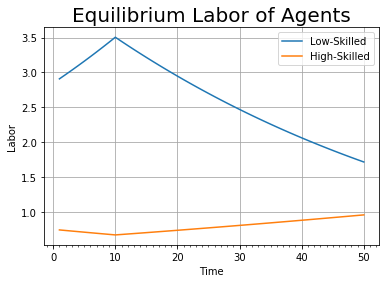

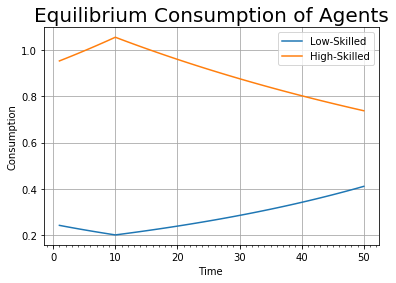

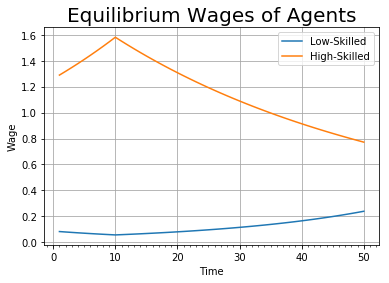

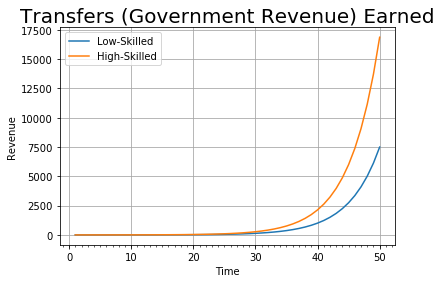

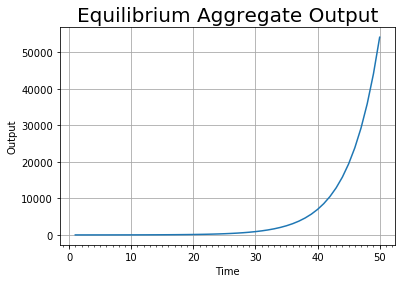

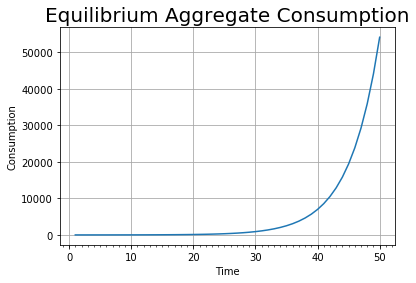

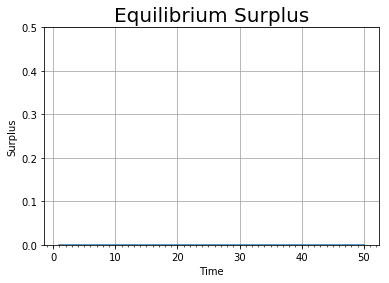

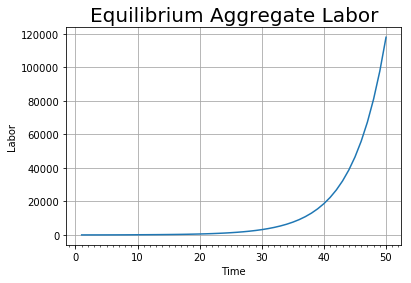

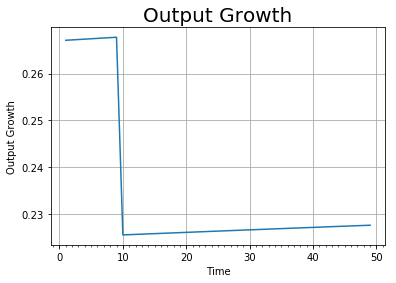

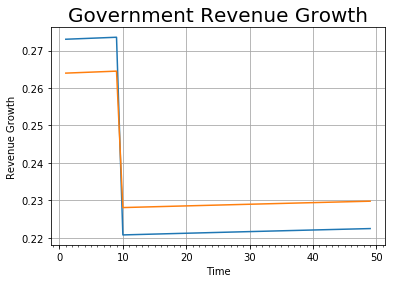

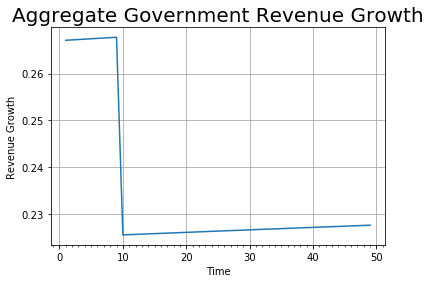

In [180]:
if graphs: 
    xvals = np.arange(1,T+1)
    fig, ax = plt.subplots()
    plt.plot(xvals, final_nvec[1,:], label="Low-Skilled")
    plt.plot(xvals, final_nvec[0,:], label="High-Skilled")
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Labor of Agents', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Labor')
    plt.legend()
    plt.savefig('labor_agents_tax.png')
    plt.show()
    plt.close

    fig, ax = plt.subplots()
    plt.plot(xvals, final_cvec[1,:], label="Low-Skilled")
    plt.plot(xvals, final_cvec[0,:], label="High-Skilled")
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Consumption of Agents', fontsize=20)
    plt.xlabel('Time ')
    plt.ylabel('Consumption')
    plt.legend()
    plt.savefig('consumption_agents_tax.png')
    plt.show()
    plt.close

    fig, ax = plt.subplots()
    plt.plot(xvals, final_wvec[1,:], label="Low-Skilled")
    plt.plot(xvals, final_wvec[0,:], label="High-Skilled")
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Wages of Agents', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Wage')
    plt.legend()
    plt.savefig('wage_agents_tax.png')
    plt.show()
    plt.close
    
    fig, ax = plt.subplots()
    plt.plot(xvals, final_gvec[1,:], label="Low-Skilled")
    plt.plot(xvals, final_gvec[0,:], label="High-Skilled")
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Transfers (Government Revenue) Earned', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Revenue')
    plt.legend()
    plt.savefig('transfer_agents_tax.png')
    plt.show()
    plt.close

    fig, ax = plt.subplots()
    plt.plot(xvals, final_yvec)
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Aggregate Output', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.savefig('output_tax.png')
    plt.show()
    plt.close

    fig, ax = plt.subplots()
    plt.plot(xvals, final_Cvec)
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Aggregate Consumption', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.savefig('consumption_agg_tax.png')
    plt.show()
    plt.close

    fig, ax = plt.subplots()
    plt.plot(xvals, final_surplus)
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Surplus', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Surplus')
    plt.ylim([0,0.5])
    plt.savefig('surplus_tax.png')
    plt.show()
    plt.close

    fig, ax = plt.subplots()
    plt.plot(xvals, final_Lvec)
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Equilibrium Aggregate Labor', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Labor')
    plt.savefig('labor_agg_tax.png')
    plt.show()
    plt.close
    
    fig, ax = plt.subplots()
    plt.plot(xvals[:-1], yvec_growth)
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Output Growth', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Output Growth')
    plt.savefig('output_growth_tax.png')
    plt.show()
    plt.close
    
    fig, ax = plt.subplots()
    plt.plot(xvals[:-1], gvec_growth[1,:], label="Low-Skilled")
    plt.plot(xvals[:-1], gvec_growth[0,:], label="High-Skilled")
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Government Revenue Growth', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Revenue Growth')
    plt.savefig('revenue_growth_tax.png')
    plt.show()
    plt.close
    
    fig, ax = plt.subplots()
    plt.plot(xvals[:-1], Gvec_growth)
    minorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.title('Aggregate Government Revenue Growth', fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Revenue Growth')
    plt.savefig('total_rev_growth_tax.png')
    plt.show()
    plt.close